In [37]:
!pip install ipython-autotime
!pip install numpy
!pip install pandas
!pip isntall fiona shapely pyproj rtree
!pip install matplotlib
!pip install seaborn
!pip install pyshp
!pip install geopandas
!pip isntall geoplot
!pip install contextily
!pip install sklearn
!pip install levenshtein
!pip install sktime[all_extras]

%load_ext autotime

You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: unknown command "isntall" - maybe you meant "install"
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: unknown command "isntall" - maybe you meant "install"
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pierre/.virtualenvs/pltk/bin/python3.8 -m pip install --upgrade pip' command.


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/fbprophet
      creating build/lib/fbprophet/stan_model
      Importing plotly failed. Interactive plots will not work.
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-w_mp2i4o/fbprophet_3b17e17f450f41e7b43e93f14a22d945/setup.py", line 122, in <module>
          setup(
        File "/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/setuptools/__init__.py", line 153, in setup
          return distutils.core.setup(**attrs)
        File "/usr/lib/python3.8/distutils/core.py", line 148, in setup
          dist.run_commands()
        File "/usr/lib/python3.8/distutils/dist.py"

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 26.8 s (started: 2022-03-21 02:36:39 +01:00)


In [40]:
import os
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import itertools
from functools import partial
import Levenshtein
from sklearn.cluster import AffinityPropagation, KMeans, MeanShift
from sktime.forecasting.arima import AutoARIMA
from tqdm import tqdm
from time import perf_counter
from pprint import pprint as pp

np.set_printoptions(precision=2)

time: 2.89 ms (started: 2022-03-21 02:39:47 +01:00)


In [41]:
## Getting the data and having a quick view of it :
## It is the dataset from https://data.sncf.com/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-semestre-2015/table/?refine.jour=2021

ds_url="https://data.sncf.com/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-semestre-2015/download/?format=csv&refine.jour=2021&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"

def download(url, dirname = os.getcwd(), destname = "dest"):
  myfile = requests.get(url)
  open("{}/{}".format(dirname, destname), 'wb').write(myfile.content)

download(ds_url, dirname=os.getcwd(), destname='dataset_sncf.csv')
ds = pd.read_csv('dataset_sncf.csv', sep=';') 

print(ds.shape)
#ds.head()

## Dropping columns we won't need and actually sorting by date:
ds = ds.drop(columns=['CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET', 'ID_REFA_LDA']) \
       .sort_values(by='JOUR') \
       #.set_index('JOUR')
    
ds.head()

(553745, 8)


,JOUR,LIBELLE_ARRET,CATEGORIE_TITRE,NB_VALD
379608,2021-01-01,ESPLANADE DE LA DEFENSE,NON DEFINI,112
210883,2021-01-01,COURCELLES,AUTRE TITRE,24
210882,2021-01-01,CORVISART,NON DEFINI,48
210881,2021-01-01,CORVISART,AUTRE TITRE,51
210880,2021-01-01,CORVISART,AMETHYSTE,44


time: 2min 36s (started: 2022-03-21 02:39:48 +01:00)


In [42]:
## Looking at unique values to handle missing or ill-shape values:
jours = ds['JOUR'].unique()
stations = ds['LIBELLE_ARRET'].unique()
titres = dict(ds['CATEGORIE_TITRE'].value_counts())
nb_vald = ds['NB_VALD'].value_counts()

print(jours)   ; print('\n')

print(stations)   ; print('\n')
## -> to standardize a bit (same cap, no dashes)

pp(titres)     ; print('\n')
## -> There are many unknown data, split between 'AUTRE TITRE', 'NON DEFINI' and '?' which are to be merged together 

## There are too many elements in nb_valds, so I just checked the format:
print(nb_vald) ; print('\n')
nb_vald = nb_vald.to_dict()
f=filter(lambda x: not str(x[0]).isnumeric(), nb_vald)

print('Non integer elements in NB_VALD:')
print(*f)      ; print('\n')
## -> jours and stations seem fine, but there is a 'Moins de 5' value that cannot be used in computing statistics.
##    I will replace it by 2.5 since the mean is likely a good approximation without further information.

['2021-01-01' '2021-01-02' '2021-01-03' '2021-01-04' '2021-01-05'
 '2021-01-06' '2021-01-07' '2021-01-08' '2021-01-09' '2021-01-10'
 '2021-01-11' '2021-01-12' '2021-01-13' '2021-01-14' '2021-01-15'
 '2021-01-16' '2021-01-17' '2021-01-18' '2021-01-19' '2021-01-20'
 '2021-01-21' '2021-01-22' '2021-01-23' '2021-01-24' '2021-01-25'
 '2021-01-26' '2021-01-27' '2021-01-28' '2021-01-29' '2021-01-30'
 '2021-01-31' '2021-02-01' '2021-02-02' '2021-02-03' '2021-02-04'
 '2021-02-05' '2021-02-06' '2021-02-07' '2021-02-08' '2021-02-09'
 '2021-02-10' '2021-02-11' '2021-02-12' '2021-02-13' '2021-02-14'
 '2021-02-15' '2021-02-16' '2021-02-17' '2021-02-18' '2021-02-19'
 '2021-02-20' '2021-02-21' '2021-02-22' '2021-02-23' '2021-02-24'
 '2021-02-25' '2021-02-26' '2021-02-27' '2021-02-28' '2021-03-01'
 '2021-03-02' '2021-03-03' '2021-03-04' '2021-03-05' '2021-03-06'
 '2021-03-07' '2021-03-08' '2021-03-09' '2021-03-10' '2021-03-11'
 '2021-03-12' '2021-03-13' '2021-03-14' '2021-03-15' '2021-03-16'
 '2021-03-

In [43]:
## Performing the adjustments found at the previous step:

ds['LIBELLE_ARRET'] = ds['LIBELLE_ARRET'].map(lambda s: s.upper().replace('-', ' ') \
                                                                 .replace('PTE', 'PORTE')) 

ds['CATEGORIE_TITRE'] = ds['CATEGORIE_TITRE'].replace('NON DEFINI', '?') \
                                             .replace('AUTRE TITRE', '?')

ds['NB_VALD'] = ds['NB_VALD'].replace('Moins de 5', 2.5).astype(float)

time: 301 ms (started: 2022-03-21 02:42:40 +01:00)


In [44]:
## Quelles sont les 20 premières stations en terme de validations ?

tbl = ds.groupby('LIBELLE_ARRET') \
        .agg(VALD_STATION=('NB_VALD', sum)) \
        .sort_values(by='VALD_STATION', ascending=False) \
        .astype(int)

print('Stations par ordre décroissant de validation (1-20) :\n')
tbl.head(20)  

Stations par ordre décroissant de validation (1-20) :



,VALD_STATION
LIBELLE_ARRET,
SAINT LAZARE,9434391
MONTPARNASSE,5216901
GARE DE L'EST,5204207
GARE DE LYON,4130244
REPUBLIQUE,3694301
LES HALLES,3548062
CHATELET LES HALLES,3433441
LA DEFENSE GRANDE ARCHE,3192773
BELLEVILLE,2779508


time: 66.7 ms (started: 2022-03-21 02:42:41 +01:00)


In [45]:
## Proposez une illustration graphique de ce classement ?

download('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr', destname='arrondissements.json')
download('https://github.com/gmonaci/playing-with-folium/blob/master/data/emplacement-des-gares-idf.csv', destname='stations.csv')

arr = gpd.read_file('arrondissements.json')
#sta = pd.read_csv('stations.csv', sep=';')
#sta.to_json('stations.json')
#sta = gpd.read_file('stations.json')

## -> I guess I had to plot a map of Paris with  big points on the 20 most visited stations,
##    with maybe bigger points with better ranks, but I didn't manage to find the geodata of the stations.

time: 1.53 s (started: 2022-03-21 02:42:42 +01:00)


In [46]:
## Proposez une classification des arrêts en vous basant 
## sur le nombre de validations par titre de transport ?

vald_station_titre = ds.groupby(['LIBELLE_ARRET', 'CATEGORIE_TITRE']) \
                       .agg(VALD_STATION_TITRE=('NB_VALD', sum)) \
                       .reset_index()

print(vald_station_titre.head(10))   ; print('\n')
titres = vald_station_titre['CATEGORIE_TITRE'].unique()
print('All ticket types in the dataset:')
print(titres)   ; print('\n')

## Converting each station in a feature vector where each component corresponds to a ticket type.
## It would have been simpler to just reshape ds.values.VALD_STATION_TITRE to (-1, len(titres))
## but this way we avoid problems in case each ticket is not present in every station.
dict_stations = {}
for row in vald_station_titre.itertuples():
    if not row.LIBELLE_ARRET in dict_stations.keys():
        dict_stations[row.LIBELLE_ARRET] = {}
    dict_stations[row.LIBELLE_ARRET][row.CATEGORIE_TITRE] = row.VALD_STATION_TITRE
    
   
for station in dict_stations.keys():
    if len(dict_stations[station].keys()) < len(titres):
        missing = set(titres).difference(set(dict_stations[station].keys()))
        print("Not all ticket types for station {}: missing {}.".format(station, ', '.join(missing)))
        for t in missing:
            dict_stations[station][t] = 0   
print('\n')

vector_stations = np.stack( [[dict_stations[s][t]  for t in dict_stations[s].keys()] for s in dict_stations.keys()] )
print('vector_stations shape: {}'.format(vector_stations.shape))

## I got the same results with KMeans with or without normalization
#vector_stations -= vector_stations.mean(axis=0)
#vector_stations /= vector_stations.var(axis=0)
#vector_stations /= (vector_stations.max(axis=0) - vector_stations.min(axis=0))


  LIBELLE_ARRET CATEGORIE_TITRE  VALD_STATION_TITRE
0      ABBESSES               ?             61834.5
1      ABBESSES       AMETHYSTE              9985.0
2      ABBESSES             FGT             10973.0
3      ABBESSES       IMAGINE R             96235.0
4      ABBESSES          NAVIGO            185734.0
5      ABBESSES     NAVIGO JOUR              1117.0
6      ABBESSES             TST             11620.0
7        ALESIA               ?            128758.5
8        ALESIA       AMETHYSTE             38639.0
9        ALESIA             FGT             35652.0


All ticket types in the dataset:
['?' 'AMETHYSTE' 'FGT' 'IMAGINE R' 'NAVIGO' 'NAVIGO JOUR' 'TST']


Not all ticket types for station ARBORETUM: missing NAVIGO JOUR.
Not all ticket types for station BEETHOVEN   CONCORDE: missing AMETHYSTE.
Not all ticket types for station CAMILLE GROULT: missing AMETHYSTE.
Not all ticket types for station CARLE   DARTHÉ: missing AMETHYSTE.
Not all ticket types for station CHRISTOPHE COLLOMB

/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, ou

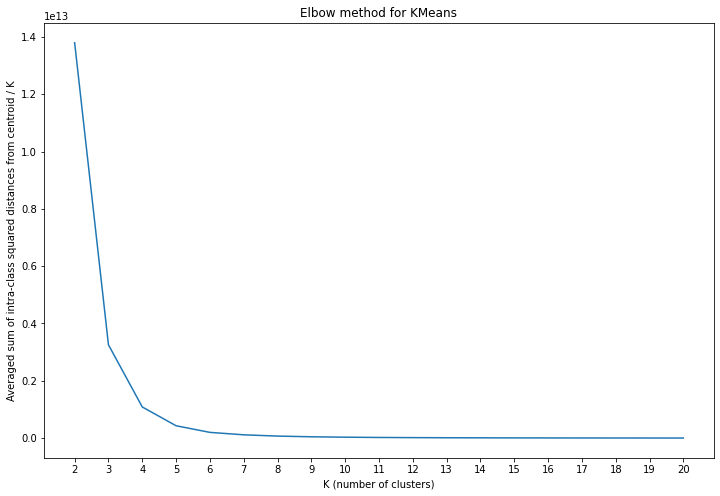

KMeans cluster centers for K=4:
[[6.39e+04 1.69e+04 1.91e+04 1.03e+05 2.62e+05 9.25e+02 2.90e+04]
 [8.28e+05 1.40e+05 3.33e+05 1.52e+06 5.91e+06 2.48e+04 6.77e+05]
 [4.80e+05 8.20e+04 1.51e+05 7.14e+05 2.36e+06 1.22e+04 2.63e+05]
 [1.94e+05 4.93e+04 6.69e+04 2.46e+05 8.10e+05 2.00e+03 1.18e+05]]




,?,AMETHYSTE,IMAGINE R,FGT,TST,NAVIGO JOUR,NAVIGO
0,63902,16904,19088,103018,261527,924,29000
1,827961,140188,332853,1519683,5911615,24777,677314
2,479877,82012,151452,713620,2358225,12157,262644
3,193532,49267,66903,245552,809796,2001,118019


time: 2.12 s (started: 2022-03-21 02:42:44 +01:00)


In [47]:
## Now the data points are in the good format for sklearn 

def elbow_method(stations, vector_stations, k_min=2, k_max=20):
    """ Evaluate the pertinence of found clusters with ratio of averaged intra-class variances and inter-class distances """
    values_x = range(k_min, k_max+1)
    values_y = []
    stations_ = pd.DataFrame(data=stations, columns=['ARRET_LIBELLE'])

    def intra_dist(row, centers):
        centroid = centers[int(row['CLUSTER'])]
        v_components = sorted([int(col_name.strip('V')) for col_name in row.keys() if col_name[0]=='V'])
        vector = np.array([row['V'+str(idx)] for idx in v_components])
        dist = np.sum(np.power(vector - centroid, 2))
        return dist # actually squared dist, as in elbow method
    
    clusteringsKM = [KMeans(n_clusters=i, random_state=123).fit(vector_stations) for i in range(k_min, k_max+1)]
    for j in range(len(clusteringsKM)):
        clustering = clusteringsKM[j]
        intra_dist_k = partial(intra_dist, centers=clustering.cluster_centers_)
        vectors = pd.DataFrame(data=vector_stations, columns=['V{}'.format(i) for i in range(1, vector_stations.shape[1]+1)])
        stations = pd.concat([stations_, vectors], axis=1)
        stations['CLUSTER'] = clustering.labels_
    
        stations['DIST_TO_CENTROID'] = stations.apply(intra_dist_k, axis=1)

        dists = stations.groupby('CLUSTER') \
                        .agg(DIST_SUM_INTRA=('DIST_TO_CENTROID', np.sum))

        values_y.append(np.mean(dists) / (k_min+j))
        
    fig = plt.figure(figsize=(12, 8))
    
    plt.plot(values_x, values_y)
    
    plt.xlabel('K (number of clusters)')
    plt.ylabel('Averaged sum of intra-class squared distances from centroid / K')
    plt.title('Elbow method for KMeans')
    
    plt.xticks(range(k_min, k_max+1))
    
    plt.show()
    
    
stations = ds['LIBELLE_ARRET'].unique()
elbow_method(stations, vector_stations)
## Elbow method: the optimal nb of clusters is when the error suddenly decrease slower
## -> Here it would be 4 for KMeans.

k=4
KM = KMeans(n_clusters=k, random_state=123).fit(vector_stations)
print('KMeans cluster centers for K={}:'.format(k))
print(KM.cluster_centers_)    ; print('\n')

titres = ds['CATEGORIE_TITRE'].unique()
km_centroids= pd.DataFrame(data=KM.cluster_centers_.astype(int), columns=titres)
km_centroids.head()


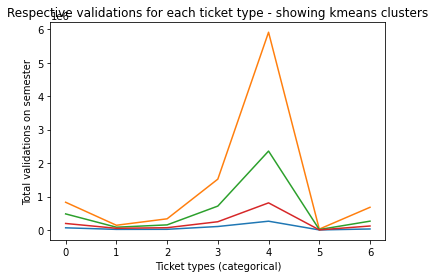

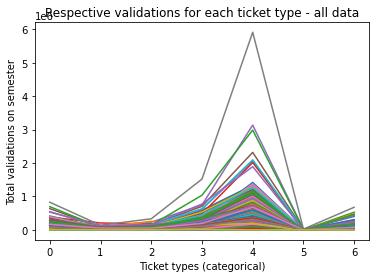

time: 704 ms (started: 2022-03-21 02:42:46 +01:00)


In [48]:
## Confronting clusters to data points distribution:

for i in range(k):
    plt.plot(range(7), km_centroids.iloc[i, :])

plt.xlabel('Ticket types (categorical)')
plt.ylabel('Total validations on semester')
plt.title('Respective validations for each ticket type - showing kmeans clusters')
plt.show()

for i in range(vector_stations.shape[0]):
    plt.plot(range(7), vector_stations[i, :])
plt.xlabel('Ticket types (categorical)')
plt.ylabel('Total validations on semester')
plt.title('Respective validations for each ticket type - all data')
plt.show()

## -> clusters seem to match the data well, even though a single sample 
##    is standing very far from other, taking a single cluster for it alone (same with k=3)

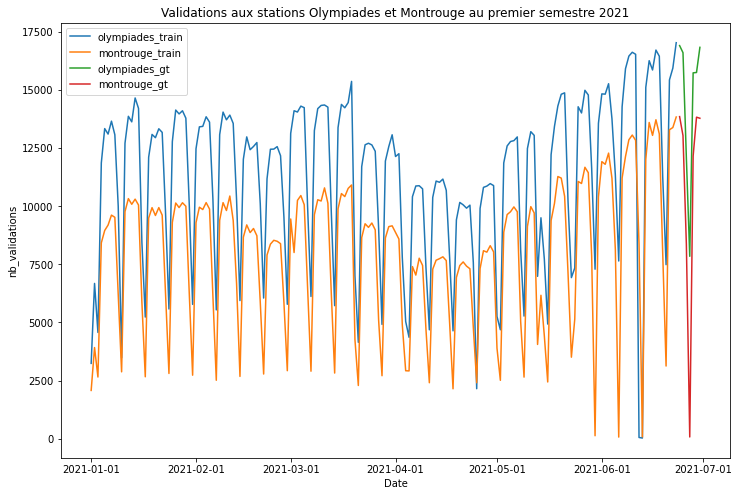

time: 380 ms (started: 2022-03-21 02:42:47 +01:00)


In [49]:
## Quelles prédictions pouvez-vous faire pour le nombre de validations 
## dans les stations "OLYMPIADES" et "MONTROUGE" sur la période du 24 au 30 juin 
## et les comparer par rapport à la réalité ?

vald_jour_station = ds.groupby(['LIBELLE_ARRET', 'JOUR']) \
                      .agg(VALD_JOUR_STATION=('NB_VALD', sum)) 

val_split = np.where(jours=='2021-06-24')[0][0]

olp = vald_jour_station.loc['OLYMPIADES']
mtr = vald_jour_station.loc['M. MONTROUGE'] # pas de station 'MONTROUGE'

fig = plt.figure(figsize=(12, 8))

plt.plot(jours[:val_split], olp.VALD_JOUR_STATION[:val_split], label='olympiades_train')
plt.plot(jours[:val_split], mtr.VALD_JOUR_STATION[:val_split], label='montrouge_train')

plt.plot(jours[val_split:], olp.VALD_JOUR_STATION[val_split:], label='olympiades_gt')
plt.plot(jours[val_split:], mtr.VALD_JOUR_STATION[val_split:], label='montrouge_gt')

plt.xlabel('Date')
plt.ylabel('nb_validations')

plt.xticks(["2021-01-01", "2021-02-01", "2021-03-01", "2021-04-01", "2021-05-01", "2021-06-01", "2021-07-01"])

plt.legend()

plt.title('Validations aux stations Olympiades et Montrouge au premier semestre 2021')

plt.show()



/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:92: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/pierre/.virtualenvs/pltk/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:92: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)


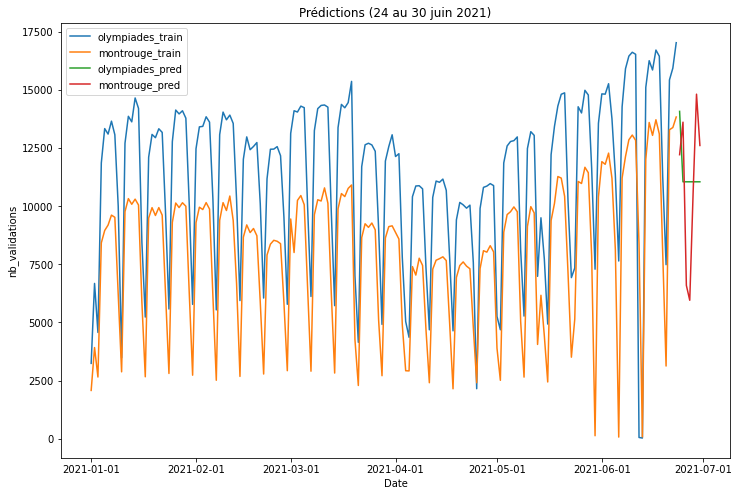

time: 8.56 s (started: 2022-03-21 02:42:49 +01:00)


In [50]:

forecaster_olp = AutoARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 7), suppress_warnings=True)
forecaster_olp.fit(olp.reset_index().VALD_JOUR_STATION[:val_split])
pred_olp = forecaster_olp.predict(fh=[1, 2, 3, 4, 5, 6, 7])

forecaster_mtr = AutoARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 7), suppress_warnings=True)
forecaster_mtr.fit(mtr.reset_index().VALD_JOUR_STATION[:val_split])
pred_mtr = forecaster_mtr.predict(fh=[1, 2, 3, 4, 5, 6, 7])


fig = plt.figure(figsize=(12, 8))

plt.plot(jours[:val_split], olp.VALD_JOUR_STATION[:val_split], label='olympiades_train')
plt.plot(jours[:val_split], mtr.VALD_JOUR_STATION[:val_split], label='montrouge_train')

plt.plot(jours[val_split:], pred_olp, label='olympiades_pred')
plt.plot(jours[val_split:], pred_mtr, label='montrouge_pred')

plt.xlabel('Date')
plt.ylabel('nb_validations')

plt.xticks(["2021-01-01", "2021-02-01", "2021-03-01", "2021-04-01", "2021-05-01", "2021-06-01", "2021-07-01"])

plt.legend()

plt.title('Prédictions (24 au 30 juin 2021)')

plt.show()


In [51]:
## Trouver 10 paires de stations dont les noms sont proches.
stations_pairs = list(itertools.combinations(stations, 2)) #stations = ds['LIBELLE_ARRET'].unique()
print(len(stations))
print(len(list(stations_pairs)))

def search_similar_names(stations_pairs, nb_trials=len(stations_pairs), nb_results=10):
    results = \
    {
        i : Levenshtein.ratio(stations_pairs[i][0], stations_pairs[i][1]) for i in range(10)
    }
    worst = min(results.values())
    
    for n in tqdm(range(nb_trials)):
        score = Levenshtein.ratio(stations_pairs[n][0], stations_pairs[n][1])
        if score > worst:
            results[n] = score
            results = dict(sorted(list(results.items()), key=lambda x: x[1], reverse=True)[:nb_results])
    
    results = sorted(list(results.items()), key=lambda x: x[1], reverse=True)
    print('\nFound similar names : ')
    for n, score in results:
        print(stations_pairs[n][0] + ' - ' + stations_pairs[n][1] + ' (score : {})'.format(score))


search_similar_names(stations_pairs)
print('\n')

 51%|█████▏    | 31139/60726 [00:00<00:00, 311385.10it/s]

349
60726


100%|██████████| 60726/60726 [00:00<00:00, 324491.33it/s]


Found similar names : 
PORTE DE SAINT CLOUD - PORTE DE SAINT OUEN (score : 0.8717948717948718)
MAIRIE D'IVRY - MAIRIE D'ISSY (score : 0.8461538461538461)
QUAI DE LA GARE - QUAI DE LA RAPEE (score : 0.8387096774193549)
SAINT MICHEL - SAINT MARCEL (score : 0.8333333333333334)
NOTRE DAME DES ANGES - NOTRE DAME DES CHAMPS (score : 0.8292682926829268)
MAIRIE ST OUEN - MAIRIE DE SAINT OUEN (score : 0.8235294117647058)
CHARONNE - CAMBRONNE (score : 0.8235294117647058)
MAIRIE DE SAINT OUEN - PORTE DE SAINT OUEN (score : 0.8205128205128205)
SAINT MAUR - SAINT MARCEL (score : 0.8181818181818181)
MAIRIE DE MONTREUIL - PORTE DE MONTREUIL (score : 0.8108108108108107)


time: 200 ms (started: 2022-03-21 02:42:58 +01:00)
